In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import IPython.display

Text(0.5, 1.0, 'Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)')

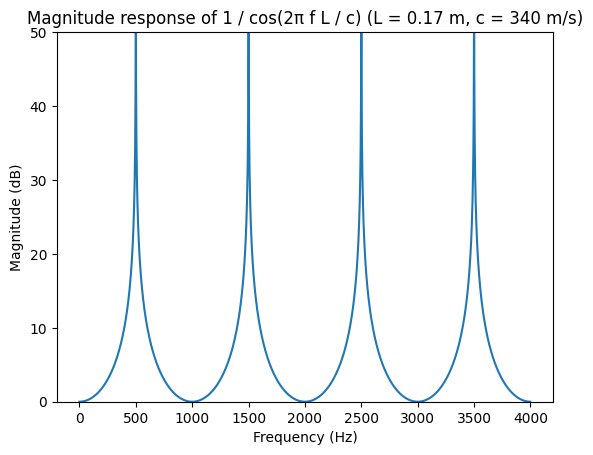

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 管の共鳴を簡易モデルで可視化するコード
#   |H(f)| = 1 / |cos(2π f L / c)|
#
# 想定している物理モデル：
#   - 長さ L の一様な音響管（声道や管楽器の非常に単純化したモデル）
#   - 音速 c [m/s]
#   - 周波数 f に対する伝達関数の大きさを
#       H(f) = 1 / cos(kL)   （k = 2π f / c）
#     という形で近似したもの（cos が 0 に近づく周波数で強い共鳴が出る）
# ============================================

# 音速 [m/s]
c = 340

# 管の長さ [m]
# 0.17 m ≒ 17 cm なので、人間の声道の平均的な長さを大まかに想定している値。
# この長さによって共鳴（フォルマント）周波数の位置が決まる。
length = 0.17

# サンプリングレート [Hz]
# ここでは 8 kHz を想定。周波数軸は 0〜fs/2（ナイキスト周波数）までを描画する。
fs = 8000

# 周波数軸 [Hz] の生成
# np.arange(0, fs/2) で 0,1,2,...,(fs/2 - 1) [Hz] を生成する。
# 離散的な周波数点で H(f) の値を計算し、周波数応答を可視化する。
frequency = np.arange(0, fs / 2)

# ============================================
# 伝達関数 H(f) = 1 / cos(2π f L / c) の大きさ |H(f)| を計算
# ============================================
# kL = 2π f L / c  は波数 k と管長 L の積に相当。
# cos(kL) が 0 に近づく周波数（共鳴周波数）で |H(f)| が非常に大きくなる。
#
# 共鳴周波数の条件：
#   cos(2π f L / c) = 0
#   ⇒ 2π f L / c = (2n+1) π/2   （n = 0,1,2,...）
#   ⇒ f = (2n+1) c / (4L)
# したがって、(2n+1) 次の奇数倍で共鳴ピークが現れる。
#
# np.abs(1/np.cos(...)) で振幅 |H(f)| を計算し、
# その後 20*log10 で dB スケールに変換してプロットする。
H_mag = np.abs(1 / np.cos(2 * np.pi * frequency * length / c))

# ============================================
# 周波数応答（振幅スペクトル）をプロット
# ============================================
plt.plot(frequency, 20 * np.log10(H_mag))

# y 軸を 0〜50 dB の範囲に制限
# 共鳴周波数付近では理論上振幅が無限大に発散するが、
# プロットとしては 0〜50 dB 程度に切ることで、
# 共鳴ピークの位置だけを見やすく表示している。
plt.ylim(0, 50)

# 軸ラベルなどを付けると、何を見ているかがより明確になる（任意）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)")

# plt.show()  # スクリプトとして実行する場合は明示的に表示する

Text(0.5, 1.0, 'Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})')

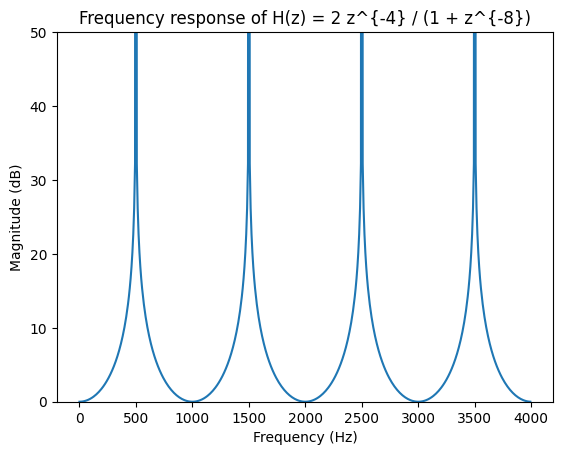

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ============================================
# IIR フィルタ（共鳴を持つフィードバック構造）の周波数特性を可視化するコード
#
# 伝達関数 H(z) = B(z) / A(z) を
#   B(z) = 2 z^{-4}
#   A(z) = 1 + z^{-8}
# とおいたときの周波数応答 |H(e^{jω})| を plot している。
#
# ・分子 B(z) = 2 z^{-4}  → 4 サンプルの純粋な遅延（位相シフト）＋ゲイン 2
# ・分母 A(z) = 1 + z^{-8} → 8 サンプル遅延フィードバックを持つ共鳴構造
#
# A(z) の零点方程式 1 + z^{-8} = 0 から、
#   z^{-8} = -1 → z = exp(j (π + 2πk) / 8), k=0,...,7
# の位置にポールが存在し、対応する周波数で共鳴（ピーク）が現れる。
# ============================================

# サンプリングレート [Hz]
sr = 8000

# ============================================
# 1. フィルタ係数 b, a の設定
# ============================================
# 信号処理ライブラリでは一般に、
#   H(z) = (b[0] + b[1] z^{-1} + ... + b[M] z^{-M}) /
#          (a[0] + a[1] z^{-1} + ... + a[N] z^{-N})
# としてフィルタを表現する。
#
# ここでは、
#   b[4] = 2  → B(z) = 2 z^{-4}
#   a[0] = 1, a[8] = 1 → A(z) = 1 + z^{-8}
#
# となるようにゼロ配列を用意したあと、必要な位置だけ代入している。
b = np.zeros(5)  # 長さ 5 の分子係数（最大 z^{-4} まで）
a = np.zeros(9)  # 長さ 9 の分母係数（最大 z^{-8} まで）

# 分子：4 サンプル遅延のタップにゲイン 2
b[4] = 2

# 分母：z^0（現在サンプル）と z^{-8} の係数を 1 に設定
#       → A(z) = 1 + z^{-8}
a[0] = 1
a[8] = 1

# ============================================
# 2. 周波数応答の計算（signal.freqz）
# ============================================
# signal.freqz(b, a) は離散時間フィルタ H(z) の周波数応答
#   H(e^{jω}) を 0〜π [rad/sample] の範囲で計算してくれる。
#
# 戻り値：
#   - w : 正規化角周波数 [rad/sample]
#   - H : 複素周波数応答 H(e^{jω})
w, H = signal.freqz(b, a)

# ============================================
# 3. 角周波数 w を実周波数 f [Hz] に変換
# ============================================
# 離散時間の角周波数 ω [rad/sample] と実周波数 f [Hz] の関係は
#   ω = 2π f / sr
# なので、
#   f = ω sr / (2π)
# として周波数軸を Hz に変換する。
f = sr * w / (2 * np.pi)

# ============================================
# 4. 振幅スペクトル（dB）のプロット
# ============================================
# np.abs(H) : 複素周波数応答の絶対値 → 振幅スペクトル |H(e^{jω})|
# 20*log10(|H|) : dB 表示に変換（音響・信号処理で一般的な表現）
#
# A(z) = 1 + z^{-8} のポール位置に対応する周波数では、
# |H| が大きくなり、グラフ上で鋭いピークとして現れる。
plt.plot(f, 20 * np.log10(np.abs(H)))

# y 軸のスケールを 0〜50 dB に制限
# 共鳴ピークが非常に高くなりうるため、見やすい範囲にクリップしている。
plt.ylim([0, 50])

# 軸ラベルなど（任意で追加）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})")

# plt.show()  # スクリプトとして実行する場合は明示的に描画